In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('../utils')
import operator_calculations as op_calc
import stats
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
#change path to where 'manuscript_data' is saved
dir_path = '/Users/costa/Repositories/max_pred_states_repo+data/manuscript_data/'

In [17]:
k_B_T = 0.5
f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
# print(list(f.keys()))
traj_matrix = np.array(f['traj_matrix'])
K_star = np.array(f['K_star'],dtype=int)[0]
m_star = np.array(f['m_star'],dtype=int)[0]
phspace = np.array(f['phspace'])
print(traj_matrix.shape)
f.close()


n_clusters=1000
f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_{}.h5'.format(k_B_T,n_clusters),'r')
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_traj = np.array(f['centers_traj'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
f.close()

(19999993, 7)


In [18]:
f = h5py.File(dir_path+'DoubleWell/tscales_compute_1000_clusters.h5','r')
print(list(f.keys()))
T_range = np.array(list(f.keys()),dtype='float')
ts_traj_T = []
for T in T_range:
    ts_traj_delay = np.array(f[str(T)]['ts_traj_delay'])
    delay_range = np.array(f[str(T)]['delay_range'])
    length = int(np.array(f[str(T)]['seq_length'])[0])
    ts_traj_T.append(ts_traj_delay)
f.close()

['0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5']


In [15]:
from sklearn.linear_model import LinearRegression

def decay_rate(lifetimes,xrange=[2,500],plot=False,min_counts=10):
    x,y = stats.cumulative_dist(lifetimes,xrange)
    y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    counts = np.array([np.sum(x==x_unique) for x_unique in np.unique(x)])
    sel = counts>min_counts
    logy = np.log(y[sel])
    x = np.sort(np.unique(x))[sel].reshape(-1,1)
    w = counts[sel]
    y = y[sel]

    reg = LinearRegression().fit(x, logy)#,sample_weight=w)
    R2 = reg.score(x, logy)

    m = reg.coef_

    b = reg.intercept_
    
    if plot==True:
        plt.title('m = {:.2f}; R2 = {:.5f}'.format(-1/m[0],R2))
        plt.scatter(x,y)
        plt.plot(x,np.exp(m*x+b))
        plt.yscale('log')
        plt.show()
    return np.abs(m[0])

def obtain_tscales_T(kt,k_B_T,delay,length,plot=False):
    f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
    labels = ma.array(f['labels_traj'],dtype=int)
    centers = np.array(f['centers_traj'])
    f.close()
    
    f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
    sim = np.array(f['simulation'])[int(K_star/2):-int(K_star/2)-1]
    f.close()   
    print(labels.shape,sim.shape)

    
    print(k_B_T,delay)
    lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
    inv_measure = op_calc.stationary_distribution(P)
    final_labels = op_calc.get_connected_labels(labels,lcs)
    n_modes=2
    R = op_calc.get_reversible_transition_matrix(P)
    eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
    eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
    phi2 = eigfunctions[:,1]
        
    #label according to potential
    cluster_traj = ma.zeros(labels.shape,dtype=int)
    cluster_traj[sim[:,0]>0] = 1
    
    split_trajs = op_calc.get_split_trajs(cluster_traj,int(length))
    data_decay_rates = []
    data_decay_times = []
    for traj in split_trajs:
        data_lifetimes = stats.state_lifetime(ma.masked_invalid(traj),dt)
        data_decay_rate = decay_rate(np.hstack(data_lifetimes),xrange=[2,500],plot=plot,min_counts=1)
        data_decay_times.append(1/data_decay_rate)
        data_decay_rates.append(data_decay_rate)
    
    #save optimal partition results
    c_range,rho_sets,_,_ = op_calc.optimal_partition(phi2,inv_measure,R,return_rho=True)
        
    return c_range,rho_sets,data_decay_times,data_decay_rates

In [12]:
delay_idx_T = np.zeros(len(T_range),dtype=int)
rate_mix_T = np.zeros((len(T_range),3))
delay_mix_T = np.zeros((len(T_range),3))
for kt,T in enumerate(T_range):
    ts_traj_delay = ts_traj_T[kt]
    mean = np.mean(1/ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(1/ts_traj_delay[:,:,0],0.5,axis=0)
    ciu = np.percentile(1/ts_traj_delay[:,:,0],99.5,axis=0)
    std = np.std(1/ts_traj_delay[:,:,0],axis=0)/2
    kd = np.argmax(mean)
    print(kd,delay_range[kd]*dt)
    rate_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])
    delay_idx_T[kt] = delay_range[kd]
    mean = np.mean(ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    delay_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])

345 17.300001
194 9.75
140 7.05
117 5.9
98 4.9500003
81 4.1
72 3.65
69 3.5
66 3.3500001


In [19]:
nseqs = len(op_calc.get_split_trajs(labels_phspace,length))

tscales_T = np.zeros((len(T_range),nseqs))
decay_rates_T = np.zeros((len(T_range),nseqs))
crange_T = []
rho_sets_T = []
for kt,k_B_T in enumerate(T_range):
    delay=delay_idx_T[kt]
    print(delay*dt)
    c_range,rho_sets,data_tscales,data_decay_rates = obtain_tscales_T(kt,k_B_T,delay,length)
    tscales_T[kt] = np.array(data_tscales)
    decay_rates_T[kt] = np.array(data_decay_rates)
    crange_T.append(c_range)
    rho_sets_T.append(rho_sets)
    print(np.mean(data_tscales),np.mean(data_decay_rates))

17.30000025779009
(19999993,) (19999993, 2)
0.5 346
20.640159714107313 0.04850871321959366
9.750000145286322
(19999993,) (19999993, 2)
0.75 195
9.990568738862944 0.10015647340013334
7.050000105053186
(19999993,) (19999993, 2)
1.0 141
6.767527985088549 0.14783718652127834
5.900000087916851
(19999993,) (19999993, 2)
1.25 118
5.178023352298602 0.19325232015417612
4.950000073760748
(19999993,) (19999993, 2)
1.5 99
4.290176141388662 0.23316663243607866
4.100000061094761
(19999993,) (19999993, 2)
1.75 82
3.6794026908917563 0.2719586022391492
3.6500000543892384
(19999993,) (19999993, 2)
2.0 73
3.305478430430269 0.3026260458379643
3.500000052154064
(19999993,) (19999993, 2)
2.25 70
3.0017142898757188 0.3332678127707339
3.35000004991889
(19999993,) (19999993, 2)
2.5 67
2.765419769928233 0.36169491588261643


In [22]:
decay_rates_T_ci = np.vstack([np.mean(decay_rates_T,axis=1),np.percentile(decay_rates_T,2.5,axis=1),np.percentile(decay_rates_T,97.5,axis=1)]).T
tscales_T_ci = np.vstack([np.mean(tscales_T,axis=1),np.percentile(tscales_T,2.5,axis=1),np.percentile(tscales_T,97.5,axis=1)]).T

# a-left

In [24]:
n_modes=15
colors_modes = plt.cm.Blues_r(np.linspace(0,.9,n_modes))

In [25]:
exp_fit_tscales = tscales_T_ci[0]

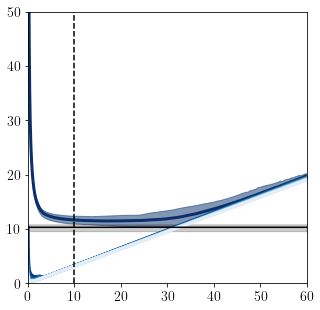

In [26]:
kt=0
ts_traj_delay = ts_traj_T[kt]
plt.figure(figsize=(5,5))
for mode in range(n_modes):
    mean = np.mean(ts_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range*dt,mean,lw=3,c=colors_modes[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_modes[mode])
plt.plot(delay_range*dt,np.ones(len(delay_range))*exp_fit_tscales[0]/2,c='k')
plt.fill_between(delay_range*dt,np.ones(len(delay_range))*exp_fit_tscales[1]/2,np.ones(len(delay_range))*exp_fit_tscales[2]/2,color='k',alpha=.2)

plt.axvline(10,c='k',ls='--')
plt.ylim(0,50)
plt.xlim(0,60)
# plt.savefig('tscales_DW_T=0.5.pdf')
plt.show()

In [27]:
#compute noise floor
k_B_T=0.5
f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
labels = ma.array(f['labels_traj'],dtype=int)
centers = np.array(f['centers_traj'])
f.close()
n_times=100
print(length)
max_eig_random = np.zeros(n_times)
for k in range(n_times):
    random_labels = np.random.choice(labels,length,replace=False)
    P_random = op_calc.transition_matrix(random_labels,1)
    R_random = op_calc.get_reversible_transition_matrix(P_random)
    eigvals_random,eigvecs = op_calc.sorted_spectrum(R_random,k=2)
    max_eig_random[k] = np.min(eigvals_random.real)
    if k%5==0:
        print(k)
    

1000000
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [28]:
kt=0
ts_traj_delay = ts_traj_T[kt]

eigvals_traj_delay = np.copy(ts_traj_delay)
for traj_idx in range(ts_traj_delay.shape[0]):
    eigvals_traj_delay[traj_idx,:,:] = np.exp(-(delay_range*dt)/ts_traj_delay[traj_idx,:,:].T).T

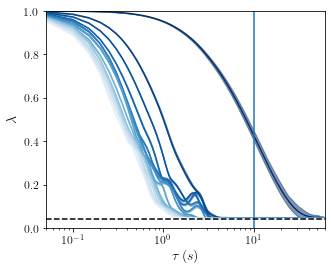

In [29]:
n_modes=15
plt.figure(figsize=(5,4))
for mode in range(n_modes):
    mean = np.mean(eigvals_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(eigvals_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(eigvals_traj_delay[:,:,mode],97.5,axis=0)
#     mean,cil,ciu=stats.bootstrap(eigvals_traj_delay[:,:,mode],median=False,n_times=1000)
    plt.plot(delay_range*dt,mean,c=colors_modes[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_modes[mode])
#     plt.plot(delay_range*dt,np.exp(-(delay_range*dt)/np.mean(ts_traj_delay,axis=0)[:,mode]),c=colors_modes[mode],marker='o',ms=3)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\tau \,(s)$',fontsize=14)
plt.ylabel(r'$\lambda$',fontsize=14)
plt.ylim(0,1)
plt.xlim(5e-2,6e1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(10)
plt.axhline(max_eig_random.mean(),c='k',ls='--')
# plt.savefig('eigvals_DW_T=0.5.pdf')
plt.show()


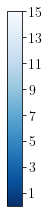

In [30]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(.25, 4.5))
img = pl.imshow(a, cmap="Blues_r",vmin=0,vmax=15)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(cax=cax,ticks=np.arange(1,16,2))
# pl.savefig("colorbar_mode_range.pdf")

# a-right

In [32]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

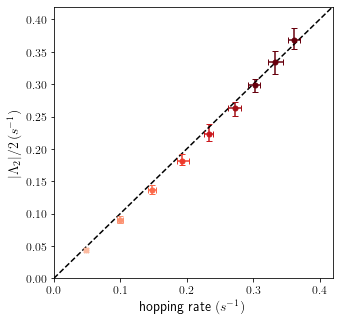

In [33]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0,.51,.02),np.arange(0,.51,.02),ls='--',c='k')

for kt in np.arange(len(T_range)):
    cil_PF = rate_mix_T[kt,0]-rate_mix_T[kt,1]
    ciu_PF = rate_mix_T[kt,2]-rate_mix_T[kt,0]
    cil_data = decay_rates_T_ci[kt,0]-decay_rates_T_ci[kt,1]
    ciu_data = decay_rates_T_ci[kt,2]-decay_rates_T_ci[kt,0]
    plt.errorbar(decay_rates_T_ci[kt,0],.5*rate_mix_T[kt,0],
                 yerr = [[.5*cil_PF],[.5*ciu_PF]],xerr = [[cil_data],[ciu_data]], c=colors_[kt],capsize=3,fmt='o',ms=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('hopping rate $(s^{-1})$ ',fontsize=14)
plt.ylabel('$|\Lambda_2|/2\, (s^{-1})$ ',fontsize=14)
plt.xlim(0,0.42)
plt.ylim(0,0.42)

# plt.savefig('hopping_rate_diagonal_idx_{}.pdf'.format(idx))
plt.show()

# b

0.042871405529532995


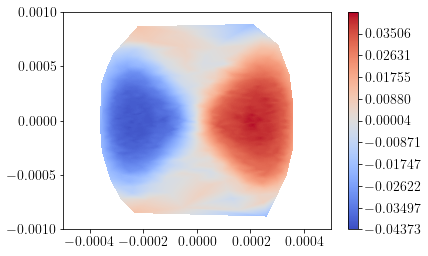

0.04809554958215476


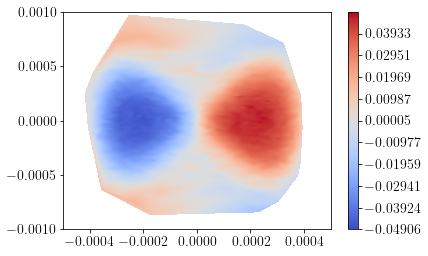

0.05257937053605498


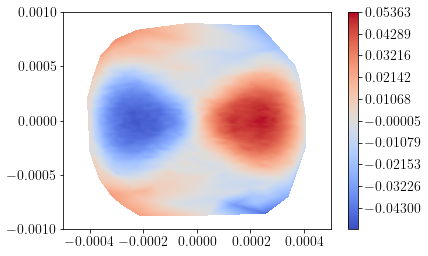

0.05537846415846148


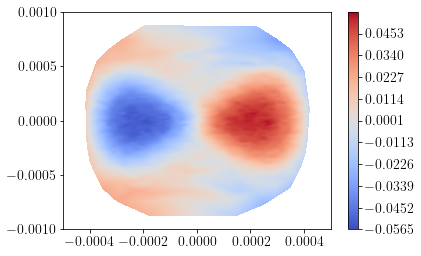

0.060241785883808255


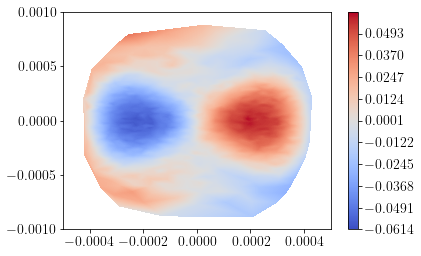

0.06331517933904367


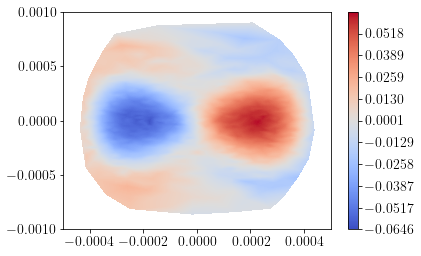

0.0641598577401055


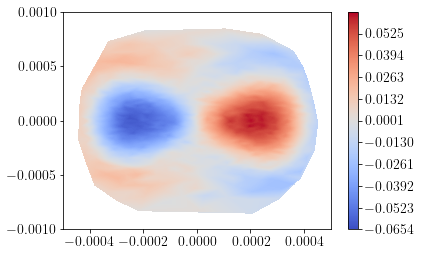

0.06605840483658874


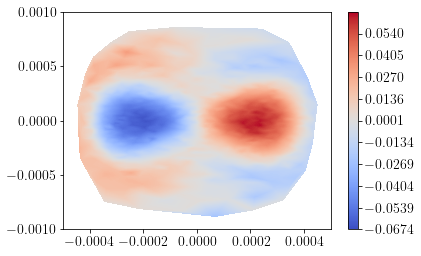

0.0693917161514629


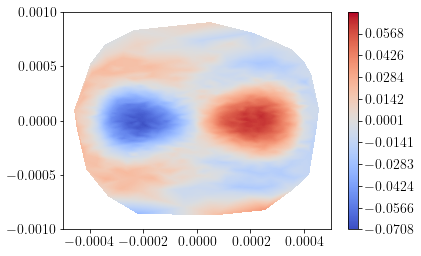

In [34]:
for kt,k_B_T in enumerate(T_range):
    delay=delay_idx_T[kt]
    f = h5py.File('/Users/costa/Repositories/manuscript_data/DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
    labels = ma.array(f['labels_phspace'],dtype=int)
    centers = np.array(f['centers_phspace'])
    f.close()

    lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
    inv_measure = op_calc.stationary_distribution(P)
    final_labels = op_calc.get_connected_labels(labels,lcs)
    n_modes=2
    R = op_calc.get_reversible_transition_matrix(P)
    eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
    eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
    phi2 = eigfunctions[:,1]

    idx = np.argmin(np.sum(np.abs(centers - np.array([-0.0003,0])),axis=1))
    if phi2[idx] > 0:
        phi2=-phi2
    
    plt.figure()
    cmax = np.max(np.abs(phi2))
    plt.tricontourf(centers[:,0],centers[:,1],phi2,cmap='coolwarm',levels=np.linspace(-1.02*cmax,1.02*cmax,1000))
    plt.xlim(-0.0005,0.0005)
    plt.ylim(-0.001,0.001)
    plt.colorbar()
    plt.show()

# FigS5

In [38]:
k_B_T=0.5
f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
# print(list(f.keys()))
traj_matrix = np.array(f['traj_matrix'])
K_star = np.array(f['K_star'],dtype=int)[0]
m_star = np.array(f['m_star'],dtype=int)[0]
phspace = np.array(f['phspace'])
f.close()
n_clusters=1000
f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_{}.h5'.format(k_B_T,n_clusters),'r')
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_traj = np.array(f['centers_traj'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
f.close()

## panel a 

In [39]:
def Boltzmann_dist(x,y,k_B_T,gamma=1):
    beta = 1/k_B_T
    return np.exp(-beta*((x**2-1)**2+gamma*y**2/2))

from sklearn.linear_model import LinearRegression

X = sim[int(K_star/2):-int(K_star/2)-1,:]
y = phspace[:,:2]
reg = LinearRegression().fit(X, y)

R2 = reg.score(X, y)

m = reg.coef_

b = reg.intercept_

centers_proj = centers_phspace.dot(np.linalg.pinv(m))

P_B_phspace = np.array([Boltzmann_dist(x_,y_,k_B_T) for x_,y_ in centers_proj])
P_B_phspace = P_B_phspace/P_B_phspace.sum()

In [40]:
kd=199
delay = int(delay_range[kd])
print(delay*dt)
P = op_calc.transition_matrix(labels_phspace,delay)
prob = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10)

PF_eigvecs = op_calc.sorted_spectrum(R.T,k=10)[1]

10.000000149011612


In [41]:
sizes = np.array([np.var(phspace[labels_phspace==label,:2] - centers_phspace[label]) for label in np.unique(labels_phspace)])
p_phspace = prob/sizes
p_phspace = p_phspace/p_phspace.sum()

In [42]:
idx = np.argmin(np.linalg.norm(centers_phspace-np.array([0.00025,0]),axis=1))
rho_0 = np.zeros(n_clusters)
rho_0[idx] = 1

n_iters= int(10000/delay)
new_rho = np.zeros((n_iters,n_clusters))
new_rho[0] = rho_0
for k in range(n_iters-1):
    new_rho[k+1,:] = (P.T).dot(new_rho[k])

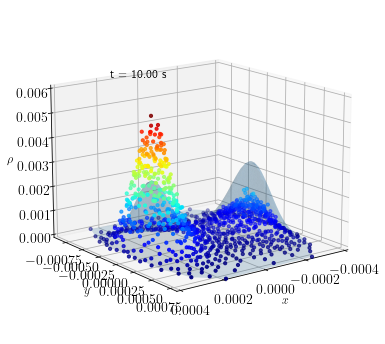

In [43]:
k=1
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
# ax.plot_trisurf(centers[:,0],centers[:,1],p,alpha=.5,cmap='jet')
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
# plt.axis('off')
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
# ax.set_zlim(0,0.08)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,6e-3)
ax.text2D(-.05, .05,  "t = {:.02f} s".format(k*delay*dt), color='k',fontsize=12)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

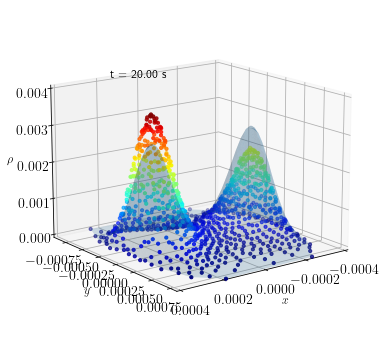

In [44]:
k=2
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,4e-3)

ax.text2D(-.05, .05,  "t = {:.02f} s".format(k*delay*dt), color='k',fontsize=12)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

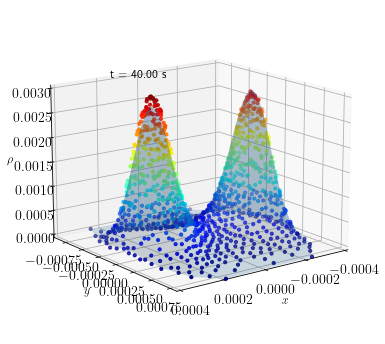

In [45]:
k=4
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(elev=15., azim=53)
p = new_rho[k,:]/sizes
p = p/p.sum()
ax.scatter(centers_phspace[:,0],centers_phspace[:,1],p,cmap='jet',c=p,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.plot_trisurf(centers_phspace[:,0],centers_phspace[:,1],P_B_phspace/P_B_phspace.sum(),alpha=.2)#,cmap='jet',c=prob,s=10)#, linewidth=0, edgecolor='none', antialiased=False)
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$',fontsize=12)
ax.set_zlabel(r'$\rho$',fontsize=12,rotation=0)
ax.set_xlim(-4e-4,4e-4)
ax.set_ylim(-9e-4,8e-4)
ax.set_zlim(0,3e-3)
plt.tight_layout()
# plt.savefig('img_{:05d}_k_B_T_{}.pdf'.format(k,k_B_T))
plt.show()

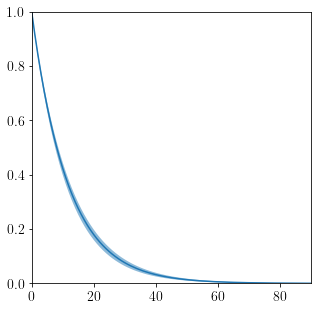

In [48]:
mean = np.mean(ts_traj_delay[:,:,0],axis=0)
cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
t_range = np.arange(0,200)
plt.figure(figsize=(5,5))
plt.plot(t_range,np.exp(-(1/mean[kd])*t_range))
plt.fill_between(t_range,np.exp(-(1/cil[kd])*t_range),np.exp(-(1/ciu[kd])*t_range),alpha=.5)
plt.xlim(0,90)
plt.ylim(0,1)
# plt.savefig('eigfun_decay_k_B_T_{}.pdf'.format(k_B_T))
plt.show()


## panel b 

In [49]:
half_tscales_T_ci = np.vstack([np.mean(tscales_T*.5,axis=1),np.percentile(tscales_T*.5,2.5,axis=1),np.percentile(tscales_T*.5,97.5,axis=1)]).T

In [50]:
y_operator = []
y_data = []
for kt in range(len(T_range)):
    ts_traj_delay = ts_traj_T[kt] #operator
    mean = np.mean(ts_traj_delay[:,:,0],axis=0) #operator
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    y_operator.append([mean,cil,ciu])
    y_data.append(tscales_T_ci[kt]/2)

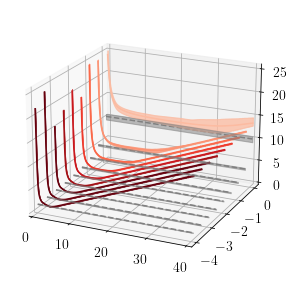

In [51]:
from mpl_toolkits.mplot3d import Axes3D
x = delay_range*dt
zmax=25.5
xmax=40.5
sel_x = x<xmax
offset=.5

plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
angles = [20,-65]
ax.view_init(angles[0],angles[1])

    
for kt in np.arange(len(T_range)):
    y = np.zeros(x.size)-kt*offset
    z_operator = y_operator[kt]
    z_data = y_data[kt]
    sel_zo = np.logical_and(x<xmax,z_operator[2]<zmax)

    ax.plot(x[sel_zo],y[sel_zo],z_operator[0][sel_zo],c=colors_[kt])
    ax.add_collection3d(plt.fill_between(x[sel_zo],z_operator[1][sel_zo],z_operator[2][sel_zo],alpha=.5,color=colors_[kt]),zs = -kt*offset,zdir='y')
    ax.plot(x[sel_x],y[sel_x],np.ones(len(mean))[sel_x]*z_data[0],c='gray',ls='--')
    ax.add_collection3d(plt.fill_between(x[sel_x],np.ones(len(mean))[sel_x]*z_data[1],np.ones(len(mean))[sel_x]*z_data[2],color='gray',alpha=.3),zs = -kt*offset,zdir='y')
ax.set_zlim3d(0,zmax)
ax.set_xlim3d(0,xmax)
# plt.xticks(np.arange(0,41,10))
# plt.yticks(np.arange(0.5,))
# plt.savefig('tscales_DW_3d_{}_{}.pdf'.format(angles[0],angles[1]))
plt.show()
    

## panel c 

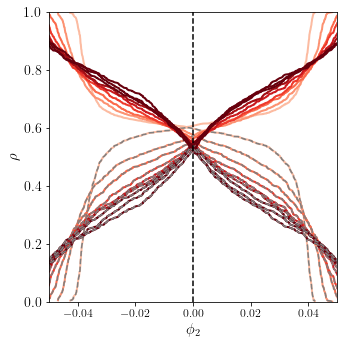

In [52]:
plt.figure(figsize=(5,5))
for kt,k_B_T in enumerate(T_range):
    c_range = crange_T[kt]
    rho_sets = rho_sets_T[kt]
    plt.plot(c_range,rho_sets[:,0],lw=2,c=colors_[kt])
    plt.plot(c_range,rho_sets[:,1],lw=2,c=colors_[kt])
    rho_c = np.min(rho_sets,axis=1)
    plt.plot(c_range,rho_c,c='gray',ls='--')
plt.ylim(0,1)
plt.xlim(-0.05,0.05)
plt.axvline(0,ls='--',c='k')
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
plt.tight_layout()
# plt.savefig('coherence_DW.pdf')
# plt.xlim(-0.04,0.04)
plt.show()